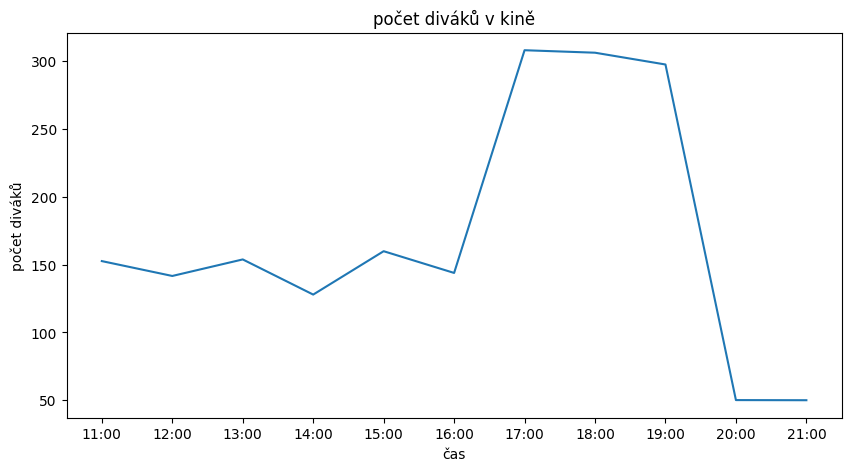

In [423]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# vstupní data
data = np.empty((30, 11), dtype=int)
for day in range(30):
    for average_hour in range(11):
        if average_hour <= 5:
            data[day][average_hour] = int(np.random.normal(150, 40))
        elif 5 < average_hour <= 8:
            data[day][average_hour] = int(np.random.normal(300, 50))
        else:
            data[day][average_hour] = int(np.random.normal(50, 10))

# vizualizace dat
average_day = np.mean(data, axis=0)
idx = np.arange(11, 22, 1)
ts = pd.Series(average_day, index=idx)

plt.figure(figsize=(10, 5))
plt.xticks(idx, [f"{i}:00" for i in idx])
plt.xlabel("čas [h]")
plt.ylabel("počet diváků")
plt.title("počet diváků v kině")

ts.plot()

# výstupní data
wait_times = []

<Axes: title={'center': 'průměrná doba čekání v kině'}, xlabel='čas [h]', ylabel='průměrná doba čekání [min]'>

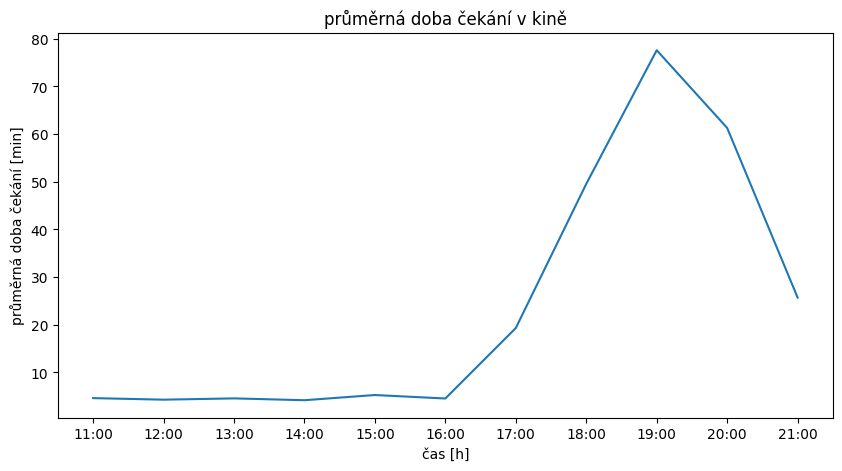

In [424]:
# Simulace
from simpy import *

env = Environment()

num_cashiers = 7
num_ushers = 4
num_servers = 10

cashier = Resource(env, capacity=num_cashiers)
usher = Resource(env, capacity=num_ushers)
server = Resource(env, capacity=num_servers)

backup_cashiers = 2
backup_ushers = 1
backup_servers = 3

backup_cashier = Resource(env, capacity=backup_cashiers)
backup_usher = Resource(env, capacity=backup_ushers)
backup_server = Resource(env, capacity=backup_servers)

def purchase_ticket(env, customer):
    yield env.timeout(max(np.random.normal(2, 1), 20 / 60))

def check_ticket(env, customer):
    yield env.timeout(max(np.random.normal(3 / 60, 1 / 60), 1 / 60))

def sell_food(env, customer):
    yield env.timeout(max(np.random.normal(3, 1), 40 / 60))

def go_to_movie(env, customer, hour):
    arrival_time = env.now

    with cashier.request() as request:
        yield request
        yield env.process(purchase_ticket(env, customer))

    with usher.request() as request:
        yield request
        yield env.process(check_ticket(env, customer))

    if np.random.choice([True] * 3 +  [False]):
        with server.request() as request:
            yield request
            yield env.process(sell_food(env, customer))

    if hour >= len(wait_times):
        wait_times.append([])

    wait_times[hour].append(env.now - arrival_time)

def run_theater(env):
    customer = 0
    for average_hour in range(11):
        num_of_customers = np.random.poisson(average_day[average_hour])
        for _ in range(num_of_customers):
            actual_hour = int(env.now / 60)
            env.process(go_to_movie(env, customer, actual_hour))
            customer += 1

            yield env.timeout(np.random.exponential(60 / num_of_customers))

env.process(run_theater(env))
env.run()

# Vizualizace výstupních dat
wait_times = [np.mean(wait_time) for wait_time in wait_times]
idx = np.arange(11, 11 + len(wait_times), 1)
ts = pd.Series(wait_times, index=idx)

plt.figure(figsize=(10, 5))
plt.xticks(idx, [f"{i}:00" for i in idx])
plt.xlabel("čas [h]")
plt.ylabel("průměrná doba čekání [min]")
plt.title("průměrná doba čekání v kině")

ts.plot()